 <img src="https://challengepost-s3-challengepost.netdna-ssl.com/photos/production/challenge_thumbnails/000/956/166/datas/original.png" width=100 align="right">
 <div style="font-size: large;"><b>Group Work</b> - Machine Learning II</div><br>
 <br>
 <br>
 <b>Group F</b><br>
 <br>
 <a href="mailto:alhagbani@student.ie.edu">Abdulaziz Alhagbani</a><br>
 <a href="mailto:juanbretti@student.ie.edu">Juan Pedro Bretti Mandarano</a><br>
 <a href="mailto:alexander.madzhirov@student.ie.edu">Aleksandar Madzhirov</a><br>
 <a href="mailto:esperanza.magpantay@student.ie.edu">Esperanza Magpantay</a><br>
 <a href="mailto:addison.pelayo@student.ie.edu">Addison Pelayo</a><br>
 <br>
 Delivery: OCT/2020<br>
 <br>
 <a href="https://www.ie.edu/school-human-sciences-technology/masters/global-master-business-analytics-big-data/">Global Master in Business Analytics and Big Data</a> | <a href="https://www.ie.edu/">IE</a>

  # Loading libraries
 Loading necessary Python libraries.

In [1]:
## Loading libraries ----

# General usage
import math
import numpy as np
import pandas as pd

# Reporting
from pandas_profiling import ProfileReport

# Preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Modeling
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef, confusion_matrix, precision_score, classification_report, accuracy_score, multilabel_confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Encoders
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import category_encoders as ce

# Scaler
from scipy.cluster import hierarchy

# SymbolicTransformer
from gplearn.genetic import SymbolicTransformer

# ReliefF
from typing import List
from skrebate import ReliefF
import random

# PCA
from sklearn.decomposition import PCA
from matplotlib.cm import get_cmap

# Model
from datetime import datetime
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, IsolationForest
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from skopt import BayesSearchCV

# Save model
import pickle


 # Loading data
 Loading the `modelling set data` from the CSV file.<br>
 We are splitting rows between `train` and `test` for this exercise. To evaluate the performance of our model.

In [2]:
## Loading data ----

df = pd.read_csv('raw/modeling_set.csv')
full_execution = False
target = 'round_winner'


In [3]:
### Split dataset ----
X = df.drop(target, axis=1)
y = df[target]

X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Train
df = X
df[target] = y

# Test
df_test = X_test
df_test[target] = y_test


 # EDA
 Exploratory data analysis (EDA) using the library `pandas_profiling`, [link to the repository](https://github.com/pandas-profiling/pandas-profiling).<br>
 This library creates a very comprehensive HTML file.<br>
 The file will be provided with this code.

In [4]:
## EDA ----
pd.set_option('display.max_rows', 100)
if full_execution:
    df.describe().T


In [5]:
if full_execution:
    profile = ProfileReport(df, title="CS:GO >> Before", minimal=True)
    profile.to_file("storage/df_report_before.html")


 # Feature construction
 Using the libraries and methods presented in class, we are constructing features to our source dataset.

 ## New column names
 For normalization inside the code, we are assigning variables to some column names.

In [6]:
### New column names ----
# OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 3\Notebooks on feature engineering\feature importance.ipynb

target = "round_winner"
target_encoded = "round_winner_encoded"
map_ = 'map'
map_encoded = 'map_encoded'


In [7]:
## Feature construction ----


 ## Feature construction
 We created ad-hoc features, based on the strategies:
 * Compare results form the two teams
 * Considering that having higher number of players and planted the bomb, defines a winner
 * Summing all the number of weapons per team
 * Appling `log` transformation to highly skewed distributions

In [8]:
### Manual feature construction ----

def feature_construction(df):
    """Manual feature construction, based on ad-hoc interpretation of the dataset.

    Args:
        df (DataFrame): Source data frame

    Returns:
        DataFrame: Same as source
    """
    # Cast `bool` to `float`
    df['bomb_planted'] = 1.*df['bomb_planted']

    # Operations between comparable columns per team
    columns_ct_compare = ['ct_score', 'ct_health', 'ct_armor', 'ct_money', 'ct_players_alive']
    columns_t_compare = ['t_score', 't_health', 't_armor', 't_money', 't_players_alive']

    for i, j in zip(columns_ct_compare, columns_t_compare):
        df[f'compare_diff_{i}'] = df[i]-df[j]
        df[f'compare_sum_{i}'] = df[i]+df[j]

    columns_compare = []
    for col in df.columns:
        if col.find('compare_') != -1:
            columns_compare.append(col)

    # Who is the game winner
    df['manual_round_winner'] = 1.*((df['bomb_planted'] == 1.) & (df['t_players_alive'] > df['ct_players_alive']))

    # Sum weapons per team
    columns_ct_weapon =['ct_weapon_ak47', 'ct_weapon_aug', 'ct_weapon_awp', 'ct_weapon_bizon', 'ct_weapon_cz75auto', 'ct_weapon_elite', 'ct_weapon_famas', 'ct_weapon_g3sg1', 'ct_weapon_galilar', 'ct_weapon_glock', 'ct_weapon_m249', 'ct_weapon_m4a1s', 'ct_weapon_m4a4', 'ct_weapon_mac10', 'ct_weapon_mag7', 'ct_weapon_mp5sd', 'ct_weapon_mp7', 'ct_weapon_mp9', 'ct_weapon_negev', 'ct_weapon_nova', 'ct_weapon_p90', 'ct_weapon_r8revolver', 'ct_weapon_sawedoff', 'ct_weapon_scar20', 'ct_weapon_sg553', 'ct_weapon_ssg08', 'ct_weapon_ump45', 'ct_weapon_xm1014', 'ct_weapon_deagle', 'ct_weapon_fiveseven', 'ct_weapon_usps', 'ct_weapon_p250', 'ct_weapon_p2000', 'ct_weapon_tec9']
    columns_ct_grenade =['ct_grenade_hegrenade', 'ct_grenade_flashbang', 'ct_grenade_smokegrenade', 'ct_grenade_incendiarygrenade', 'ct_grenade_molotovgrenade', 'ct_grenade_decoygrenade']
    columns_t_weapon = ['t_weapon_ak47', 't_weapon_aug', 't_weapon_awp', 't_weapon_bizon', 't_weapon_cz75auto', 't_weapon_elite', 't_weapon_famas', 't_weapon_g3sg1', 't_weapon_galilar', 't_weapon_glock', 't_weapon_m249', 't_weapon_m4a1s', 't_weapon_m4a4', 't_weapon_mac10', 't_weapon_mag7', 't_weapon_mp5sd', 't_weapon_mp7', 't_weapon_mp9', 't_weapon_negev', 't_weapon_nova', 't_weapon_p90', 't_weapon_r8revolver', 't_weapon_sawedoff', 't_weapon_scar20', 't_weapon_sg553', 't_weapon_ssg08', 't_weapon_ump45', 't_weapon_xm1014', 't_weapon_deagle', 't_weapon_fiveseven', 't_weapon_usps', 't_weapon_p250', 't_weapon_p2000', 't_weapon_tec9']
    columns_t_grenade = ['t_grenade_hegrenade', 't_grenade_flashbang', 't_grenade_smokegrenade', 't_grenade_incendiarygrenade', 't_grenade_molotovgrenade', 't_grenade_decoygrenade']

    df['columns_ct_weapon'] = df.loc[:, columns_ct_weapon].sum(axis=1)
    df['columns_ct_grenade'] = df.loc[:, columns_ct_grenade].sum(axis=1)
    df['columns_t_weapon'] = df.loc[:, columns_t_weapon].sum(axis=1)
    df['columns_t_grenade'] = df.loc[:, columns_t_grenade].sum(axis=1)

    df['columns_ct_weapon_grenade'] = df.loc[:, ['columns_ct_weapon', 'columns_ct_grenade']].sum(axis=1)
    df['columns_t_weapon_grenade'] = df.loc[:, ['columns_t_weapon', 'columns_t_grenade']].sum(axis=1)

    # Apply log to some columns
    # 'ct_score', 't_score', 
    columns_log = ['time_left', 'ct_health', 't_health', 'ct_armor', 't_armor', 'ct_money', 't_money']
    df[columns_log] = df[columns_log].apply(lambda x: np.log(x+1))

    # # Drop column 'time_left'
    # df.drop(['time_left'], axis=1, inplace=True)

    return df

df = feature_construction(df)


 ## Remove and filtering
 Using several of the techniques presented in class, we remove and filter rows and columns.<br>
 For example,
 * columns where all the values are NA,
 * columns with the same value in all the column,
 * duplicate rows
 * and others

In [9]:
### Remove and filtering ----

def remove_and_filtering(df):
    """Removes and filters rows based on number of NA, constant values, high cardinality, missing values and duplicates.

    Args:
        df (DataFrame): Source data

    Returns:
        DataFrame: Same structure DataFrame
    """
    # Remove fully NA columns
    print('** Remove fully NA columns')
    print(f'Shape before {df.shape}')
    df.dropna(axis='columns', how='all', inplace=True)
    print(f'Shape after {df.shape}')

    # Remove constant value columns
    print('** Remove constant value columns')
    print(f'Shape before {df.shape}')
    col_unique = df.columns[df.nunique()==1]
    df.drop(col_unique, axis=1, inplace=True)
    print(f'Shape after {df.shape}')

    # Remove duplicate rows
    print('** Remove duplicate rows')
    print(f'Number of duplicates {df.duplicated().sum()} rows to be removed')
    df.drop_duplicates(inplace=True)

    return df

df = remove_and_filtering(df)


** Remove fully NA columns
Shape before (59980, 114)
Shape after (59980, 114)
** Remove constant value columns
Shape before (59980, 114)
Shape after (59980, 108)
** Remove duplicate rows
Number of duplicates 1771 rows to be removed


 ## TargetEncoder
 The following, converts the categorical columns into numerical.<br>
 It assigns an `integer` to each categorical `string`.<br>
 We tested using `pd.get_dummies` and also `LabelEncoder`, the second with not significant difference in results. Because we are running this model in a computer with high amount of RAM, we are going to use for the final model `One-Hot Encoding`.<br>

In [10]:
### TargetEncoder ----
# OneDrive/GMBD/MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)/Session 4 - Feature Engineering/FE BlindCredit example (original 2).ipynb

def one_hot_encoder(df, column_):
    """One hot encoder using Pandas

    Args:
        df (DataFrame): Source data

    Returns:
        DataFrame: Same as source
    """
    dummied = pd.get_dummies(df, drop_first=True, columns=column_)
    return dummied

def label_encoder(df, col_source, col_target, encoder=None):
    """Encode columns from string to integers.

    Args:
        df (DatFrame): Source data
        col_source (str): Name of the column to encode
        col_target (str): New name of the column to encode
        encoder (obj, optional): Object of the type 'LabelEncoder'. Defaults to None.

    Returns:
        DataFrame: Same as source
        Encoder: From the type 'LabelEncoder' 
    """
    if encoder is None:
        encoder = LabelEncoder()
        encoder.fit(df[col_source])
    col = encoder.transform(df[col_source])
    df[col_target] = col
    df = df.drop(col_source, axis=1)
    return df, encoder

# df, enc_le_map = label_encoder(df, map_, map_encoded)
df = one_hot_encoder(df, [map_])
df, enc_le_target = label_encoder(df, target, target_encoded)

# For map_
def target_encoder(df, target_encoded, encoder=None):
    """Encode the column 'map' into a float, using the information from 'target_encoded'.

    Args:
        df (DataFrame): Source data
        target_encoded (str): Target column
        encoder (obj, optional): Object of the type 'TargetEncoder'. Defaults to None.

    Returns:
        DataFrame: Same as source
        Encoder: From the type 'TargetEncoder'
    """
    df_cat = df.loc[:, target_encoded]
    if encoder is None:
        encoder = ce.target_encoder.TargetEncoder(cols=map_encoded)
        encoder.fit(df.drop(target_encoded, axis=1), df[target_encoded])
    df = encoder.transform(df.drop(target_encoded, axis=1), df[target_encoded])
    df = pd.concat([df.reset_index().drop(columns="index"), df_cat.reset_index().drop(columns="index")], axis=1)
    return df, encoder

# df, enc_target = target_encoder(df, target_encoded)


 ## StandardScaler
 Using the method `StandardScaler`, we are converting the numerical values into a continuos values.<br>
 This converts the `integers` into continuos `floats`.<br>
 We also tried with `RobustScaler`, with not improvement in the model accuracy. This is why we are leaving for the final model `StandardScaler`.

In [11]:
### StandardScaler ----
# OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 9 - Forum - Dimensionality Reduction\Notebook on PCA\PCA solved_v2.ipynb
# Set a variable (features) with the names of all the features BUT the target variable.

def scaler_transform(df, target_encoded, encoder=None):
    """Normalize numerical columns.

    Args:
        df (DataFrame): Data source
        target_encoded (str): Target column name
        encoder (obj, optional): Object of the type 'StandardScaler'. Defaults to None.

    Returns:
        DataFrame: Same as source
        Encoder: From the type 'StandardScaler'
    """
    df_cat = df[target_encoded]
    df_columns = df.columns
    if encoder is None:
        encoder = StandardScaler()
        encoder.fit(df.drop(target_encoded, axis=1))
    df = encoder.transform(df.drop(target_encoded, axis=1))
    df = pd.DataFrame(df, columns = df_columns[:-1])
    df = pd.concat([df.reset_index().drop(columns="index"), df_cat.reset_index().drop(columns="index")], axis=1)
    columns_ = df.columns
    return df, encoder, columns_

df, enc_scaler, columns_scaler = scaler_transform(df, target_encoded)


 ## Correlation
 Calculating `correlation` between variables.<br>
 This `correlation` will help to filter highly correlated columns.<br>

In [12]:
### Correlation ----

def correlation_plot(df, target_encoded):
    """Plot a sorted correlation plot.

    Args:
        df (DataFrame): Source data
        target_encoded (str): Target column
    """
    scaler = StandardScaler()
    df_ = df.drop(target_encoded, axis=1).select_dtypes(exclude=['object'])
    df_ = scaler.fit_transform(df_)
    cov = np.cov(df_, rowvar=False)
    order = np.array(hierarchy.dendrogram(hierarchy.ward(cov),no_plot=True)['ivl'], dtype="int")

    plt.imshow(cov[order, :][:, order])

# https://stackoverflow.com/a/63536382/3780957
def correlation_threshold(x: pd.DataFrame, bound: float):
    """Filters the provided DataFrame based on the threshold defined at 'bound' parameter.

    Args:
        x (pd.DataFrame): Source DataFrame
        bound (float): Threshold to limit the correlation.

    Returns:
        DataFrame: Filtered DataFrame
    """
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

def correlation_filter(df, threshold=0.99):
    """Filters data based on the correlation.

    Args:
        df (DataFrame): Source data
        threshold (float, optional): Threshold for the filter. Defaults to 0.99.

    Returns:
        DataFrame: Same as source
    """
    cor_ = correlation_threshold(df, threshold)
    df.drop(cor_.reset_index()['level_1'], axis=1, inplace=True)
    return df


# https://stackoverflow.com/a/25733562/3780957

if full_execution:
    correlation_plot(df, target_encoded)    
print('Correlation filter')
print(f'Shape before {df.shape}')
df = correlation_filter(df, .90)
print(f'Shape after {df.shape}')


Correlation filter
Shape before (58209, 114)
Shape after (58209, 99)


 ## SymbolicTransformer
 This method presented in class, transform and creates features using multiple operations. This will add new features to the data frame.

In [13]:
### SymbolicTransformer ----
# OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 4 - Feature Engineering\FE BlindCredit example (original 2).ipynb

def symbolic_transformer(X, y, encoder=None):
    """Transform features using multiple operations. This will add new features to the data frame.

    Args:
        X (DataFrame): Independent features
        y (Series): Dependen feature or target
        encoder (obj, optional): Object of the type 'SymbolicTransformer'. Defaults to None.

    Returns:
        DataFrame: Additional columns calculated by the algorithm
    """
    if encoder is None:
        function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                        'abs', 'neg', 'inv', 'max', 'min']
        encoder = SymbolicTransformer(generations=10,
                                population_size=1000,
                                hall_of_fame=100,
                                n_components=12,
                                function_set=function_set,
                                parsimony_coefficient=0.0005,
                                max_samples=0.9,
                                verbose=1,
                                random_state=123,
                                n_jobs=-1)
        encoder.fit(X, y)
    gp_features = encoder.transform(X)

    return gp_features, encoder

def symbolic_transformer_fit(df, encoder=None):
    """Application of the 'SymbolicTransformer' in our data model

    Args:
        df (DataFrame): Source data
        encoder (obj, optional): Object from the type 'SymbolicTransformer'. Defaults to None.

    Returns:
        DataFrame: Same as source
        encoder: Object from the type 'SymbolicTransformer'
        columns: list of additional columns created
    """
    gp_features, enc_gp = symbolic_transformer(df.drop(target_encoded, axis=1), df[target_encoded], encoder)

    columns_ = df.columns

    df_new_features = pd.DataFrame(gp_features)
    df_new_features.columns = ['gp{}'.format(i) for i in range(len(list(df_new_features)))]

    df = pd.concat([df.reset_index().drop(columns="index"), df_new_features], axis=1)

    return df, enc_gp, columns_

df, enc_gp, columns_symbolic = symbolic_transformer_fit(df)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.02        0.0645523        4         0.541896         0.519787     40.75s
   1     6.08         0.218831        1         0.542249         0.525415     16.21s
   2     3.60         0.380083        4         0.548256         0.542652     13.33s
   3     1.60         0.523747        4          0.54927         0.533362      9.30s
   4     1.92         0.501656        4         0.549649         0.529955      7.64s
   5     3.90         0.479394        5         0.550754         0.529971      6.59s
   6     4.23         0.483518        5         0.550717         0.530493      5.02s
   7     4.35         0.494151        5         0.550822         0.529653      3.37s
   8     4.56         0.476029        5         0.551391         0.551479  

 # Feature importance
 In the following section we will select the most relevant features. These will be source for our ML model.

In [14]:
## Feature importance ----


 ## Outliers
 In the following section, we filter `outliers` datapoint.<br>
 Particularly, we tried the algorithm `IsolationForest`. <br>

In [15]:
### Outliers ----

def outliers_isolation_forest(df, target_encoded, encoder=None, contamination=0.001):
    """Using 'Isolation Forest', filters the outliers data points

    Args:
        df (DataFrame): Source data
        target_encoded (str): Target column name
        encoder (obj, optional): Object of the type 'IsolationForest'. Defaults to None.
        contamination (float, optional): Threshold to remove the outliers. Defaults to 0.001.

    Returns:
        DataFrame: Same as source
    """
    if encoder is None:
        encoder = IsolationForest(contamination=contamination)
        y_pred = encoder.fit(df.drop([target_encoded], axis=1))
    y_pred = encoder.predict(df.drop([target_encoded], axis=1))
    mask = y_pred != -1
    df = df.loc[list(mask), :]
    return df, encoder

print(f'Shape before {df.shape}')
df, enc_outliers = outliers_isolation_forest(df, target_encoded)
print(f'Shape after {df.shape}')


Shape before (58209, 111)
Shape after (58150, 111)


 ## RelieF Algorithm [not in use]
 We try to use an implementation RELIEF algorithm that we can find [here](https://github.com/EpistasisLab/scikit-rebate). We will simply specify how many neighbors to consider when comparing each feature with the rest, to measure differences, and how many features do we want at the end of the process.<br>
 The only caveat is the algorithm expects the values as Numpy arrays with shapes $(m, p)$ for the features ($m$ is the number of tuples/samples and $p$ is the number of predictors/features), and $(m, 1)$ for the target variable (a 1D numpy array, for which we must use the function `ravel()` from Numpy).
 After several tries, we decided to not include this algorithm in the final pipeline, because the elimination of columns is not improving the `accuracy` of the model.

In [16]:
### ReliefF ranking [not in use] ----
# OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 3\Notebooks on feature engineering\feature importance.ipynb
# Feature importance
# Filters

def plot_importance(features: List[str], importances: List[float]):
    """Plot the variable importance of the data frame

    Args:
        features (List[str]): Features to be included in the plot
        importances (List[float]): Float of the value importance per feature
    """

    num_features = len(features)
    indices = np.argsort(importances)

    plt.figure(figsize=(8, 10))
    plt.title("Feature importances")
    plt.barh(range(num_features), importances[indices],
             color="r",
             xerr=np.std(importances),
             align="center")
    plt.yticks(range(num_features), features[indices])
    plt.ylim([-1, num_features])
    plt.show()

def importance_relieff(X, y, n_features_to_select, n_neighbors, sample_rows, encoder=None, plot=True):
    """Utilization of the algorithm ReliefF in our dataframe

    Args:
        X (DataFrame): Independent variables
        y (Series): Dependen variable or target
        n_features_to_select (int): Number of features to be in the resulting DataFrame
        n_neighbors (int): Number of neighbors to be condered for the model
        sample_rows (int): Number of sample rows
        encoder (obj, optional): Object from the type 'ReliefF'. Defaults to None.
        plot (bool, optional): Controls to show or not the 'plot_importance'. Defaults to True.

    Returns:
        DataFrame: Same as source
    """

    sample = random.sample(list(X.index), sample_rows)
    sample_features = X.iloc[sample, :].to_numpy()
    sample_labels = y.iloc[sample].to_numpy()

    if encoder is None:
        encoder = ReliefF(n_features_to_select=n_features_to_select, n_neighbors=n_neighbors)
        encoder.fit(sample_features, sample_labels)
    my_important_features = encoder.transform(sample_features)

    print("No. of tuples, No. of Columns before ReliefF : "+str(sample_features.shape)+
        "\nNo. of tuples, No. of Columns after ReliefF : "+str(my_important_features.shape))

    # Plot the importances, taken from the `encoder` variable.
    if plot:
        plot_importance(X.columns, abs(encoder.feature_importances_))

    # Get the most important column names
    my_important_features_names  = [X.columns[i] for i in abs(encoder.top_features_)]

    # Create a DataFrame
    X = pd.DataFrame(X, columns=my_important_features_names[:my_important_features.shape[1]])

    return X, encoder


def importance_relieff_fit(df, target_encoded, encoder=None, plot=True):
    """Implementation of the algorithm 'ReliefF'.

    Args:
        df (DataFrame): Source data
        target_encoded (str): Target column name
        encoder (obj, optional): Object of the type 'ReliefF'. Defaults to None.
        plot (bool, optional): Controls to show or not the 'plot_importance'. Defaults to True.

    Returns:
        DataFrame: Same as source
        encoder: Object of the type 'ReliefF'
        columns: List of columns in the resulting data frame 
    """
    df = df.reset_index().drop(columns="index")
    X = df.drop(target_encoded, axis=1)
    y = df[target_encoded]
    X_transformed, encoder = importance_relieff(X, y, n_features_to_select=50, n_neighbors=10, sample_rows=10000, encoder=encoder, plot=plot)
    df = pd.concat([X_transformed.reset_index().drop(columns="index"), y.reset_index().drop(columns="index")], axis=1)
    columns_ = df.columns
    return df, encoder, columns_

# This filter is not being used. Because the 'accuracy' is better without this filter.
# df2, enc_relieff, columns_relieff = importance_relieff_fit(df, target_encoded)


 ## PCA
 The following is an implementation of the `Principal Component Analysis`.<br>

In [17]:
### PCA ----
# OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 9 - Forum - Dimensionality Reduction\Notebook on PCA\PCA_v2.ipynb

name = "Accent"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

def pca_transform(data, target, n=2, encoder=None):
    """Applies the principal component algorithm to the data frame.

    Args:
        data (DataFrame): Source data
        target (str): Column name
        n (int, optional): Number of components to be calculated. Defaults to 2.
        encoder (obj, optional): Object of the type 'PCA'. Defaults to None.

    Returns:
        DataFrame: Same as source
        List: Variance explained by each PC.
        Encoder: Object of the type 'PCA'
    """
    if encoder is None:
        encoder = PCA(n_components=n)
        encoder = encoder.fit(data.drop([target], axis=1))
    principalComponents = encoder.transform(data.drop([target], axis=1))
    explained_pca = encoder.explained_variance_ratio_

    data_pca1 = pd.DataFrame(data=principalComponents).reset_index().drop(columns="index")
    data_pca2 = data[target].reset_index().drop(columns="index")
    data_pca = pd.concat([data_pca1, data_pca2], axis=1)

    # Setting columns name
    columns = [f"PC{s}" for s in range(1, n + 1)]
    columns.append(target)
    data_pca.columns = columns

    return data_pca, explained_pca, encoder

# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
def pca_plot_scatter(data, target, axis1=1, axis2=2):
    """Plots the PCA using a scatter plot.

    Args:
        data (DataFrame): Source data
        target (str): Target column name
        axis1 (int, optional): Number of the PC to be plotted. Defaults to 1.
        axis2 (int, optional): Number of the PC to be plotted. Defaults to 2.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(f"Principal Component {axis1}", fontsize=15)
    ax.set_ylabel(f"Principal Component {axis2}", fontsize=15)
    ax.set_title("Component PCA", fontsize=20)
    targets = data[target].unique()
    for target_, color in zip(targets, colors):
        indicesToKeep = data[target] == target_
        ax.scatter(
            data.loc[indicesToKeep, f"PC{axis1}"],
            data.loc[indicesToKeep, f"PC{axis2}"],
            color=color,
            s=50,
        )
    ax.legend(targets)
    ax.grid()

def pca_plot_density(data, target):
    """Plots the PCA using densities

    Args:
        data (DataFrame): Source data
        target (str): Target column name
    """
    # categories = data[target].unique()
    category_series = data[target]

    fig, axs = plt.subplots(3, 3)
    fig.set_size_inches(14, 10)

    feature_names = list(set(data.columns) - set([target]))

    for subplot, feature in enumerate(feature_names):
        x, y = int(subplot / 3), subplot % 3
        for value in data[target].unique():
            sns.distplot(
                data[feature][category_series == value],
                hist=False,
                kde=True,
                kde_kws={"shade": True},
                label=str(value),
                ax=axs[x, y],
            )
        axs[x, y].set_title(feature)

    plt.tight_layout()
    plt.show()


In [18]:
df, df_explained_variance, enc_pca = pca_transform(data=df, target=target_encoded, n=19)
if full_execution:
    print(np.cumsum(df_explained_variance).round(4))
    pca_plot_scatter(data=df, target=target_encoded, axis1=1, axis2=2)


 # EDA after preprocessing
 This step is for internal control of the **preprocessing** steps.

In [19]:
## EDA after preprocessing ----
if full_execution:
    profile = ProfileReport(df, title="CS:GO >> After", minimal=True)
    profile.to_file("storage/df_report_after.html")


In [20]:
## Training model ----


 # Training model
 We have no mayor problems to create the training dataset, because we have `balanced` target.<br>
 Follwing, different **machine learning** models will be tested. We will select the one that provides us the highest `accuracy`.

## Auxiliary functions
 The following functions were included as helpers for the training, plot and timing.

In [21]:
### Auxiliary functions ----
# OneDrive\GMBD\MACHINE LEARNING II (MBD-EN-BL2020J-1_32R202_380379)\Session 5 - EvaluationMetrics\Evaluation and Validation.ipynb

def plot_scores(scores, labels):
    """
    Receives scores (one or several arrays) and plots a scatter to the left with
    the values of the first one, and a boxplot with all of them to the right.
    
    Arguments
        scores: single list of scores, or list of lists of scores.
        labels: single label or list of labels identifying the scores passed
    """
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Scores from {}.'.format(labels[0]))
    plt.scatter(range(len(scores[0])), scores[0])
    plt.axhline(np.median(scores[0]), color='orange', linestyle='--', linewidth=0.5)
    
    plt.subplot(1, 2, 2)
    plt.title('{} scores stdev={:.4f}'.format(labels[0], np.std(scores[0])))
    for i in range(len(scores)):
        plt.axhline(np.median(scores[i]), color='orange', 
                    linestyle='--', linewidth=0.5)
    plt.boxplot(scores, labels=labels)
    plt.ylim(bottom=0.6, top=1.0)
    
    plt.show()

def timer(start_time=None):
    """Create a 'timer' object to measure execution time 

    Args:
        start_time (datetime[64], optional): End time when set. Defaults to None.

    Returns:
        str: Time elapsed since execution
    """
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

X = df.drop([target_encoded], axis=1)
y = df[target_encoded]


 ## LogisticRegression
 The first model we are going to train is `LogisticRegression`.<br>
 It does not have any relevant tunning parameter.

Accuracy: 0.7503 (+/- 0.01)


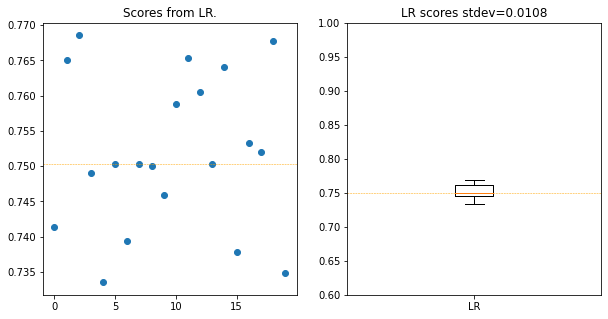

In [22]:
### LogisticRegression ----
lr_model = LogisticRegression()
lr_scores = cross_val_score(lr_model, X, y, scoring='accuracy', cv=20, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(lr_scores), np.std(lr_scores)))
plot_scores([lr_scores], ['LR'])


 ## RandomForestClassifier
 We also trained the `RandomForestClassifier` using the default parameters. This is a random forest classifier.

Accuracy: 0.8284 (+/- 0.00)


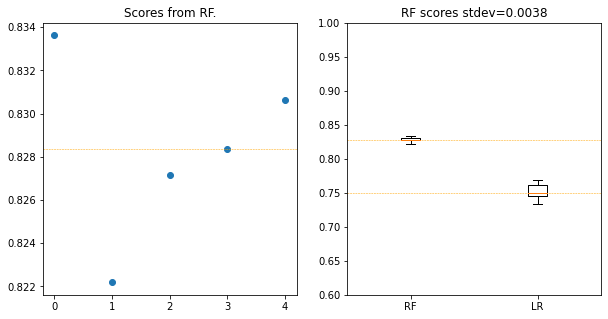

In [23]:
### RandomForestClassifier ----
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

rf_model = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_scores = cross_val_score(rf_model, X, y, scoring='accuracy', cv=5)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(rf_scores), np.std(rf_scores)))
plot_scores([rf_scores, lr_scores], ['RF', 'LR'])


 ### Hyperparameter tunning `RandomForestClassifier`, grid search
 Having such impressive results from this algorithm, we are tunning the hyperparameters. In particular, we are using `GridSearchCV` with a `cross validation`.

In [24]:
#### Hyperparameter tunning RandomForestClassifier, grid search ----

params = {
    'n_estimators': [200, 600],
    'max_depth': [30, 100],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 2, 5] 
    }
cv_ = 3

rf_model_grid = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_model_search = GridSearchCV(rf_model_grid, param_grid=params, scoring='accuracy', n_jobs=-1, cv=cv_, verbose=3)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
rf_model_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 out of  72 | elapsed:  6.6min remaining:   36.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  6.9min finished



 Time taken: 0 hours 7 minutes and 7.27 seconds.


 Checking the accuracy of the best model

Accuracy: 0.8235 (+/- 0.00)


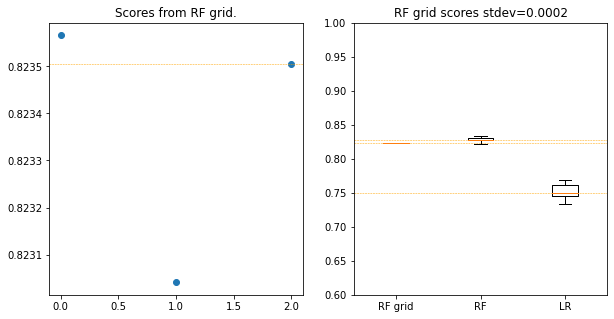

In [25]:
# Checking the accuracy of the best model

rf_model_after_search = rf_model_search.best_estimator_
rf_model_after_search_scores = cross_val_score(rf_model_after_search, X, y, scoring='accuracy', cv=3, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(rf_model_after_search_scores), np.std(rf_model_after_search_scores)))
plot_scores([rf_model_after_search_scores, rf_scores, lr_scores], ['RF grid', 'RF', 'LR'])


 ### Hyperparameter tunning RandomForestClassifier, bayesian search
 Five different parameters will be tunned using random search.<br>
 The performance of this algorithm hasn't improved. For speeding up this *notebook*, we had reduced the number of *parameter combination*.

In [26]:
#### Hyperparameter tunning RandomForestClassifier, bayesian search ----
# https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn
# https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html
# https://neptune.ai/blog/scikit-optimize

params = {
    'n_estimators': [200, 600, 1200],
    'max_depth': [30, 100, 200],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 2, 5] 
    }

folds = 3
param_comb = 100
cv_ = 3

rf_model_bayes = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_model_bayes_search = BayesSearchCV(rf_model_bayes, search_spaces=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=cv_, verbose=3, random_state=42)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
rf_model_bayes_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   50.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   50.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   50.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   48.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.2s finished



 Time taken: 1 hours 7 minutes and 27.68 seconds.


Accuracy: 0.8384 (+/- 0.00)


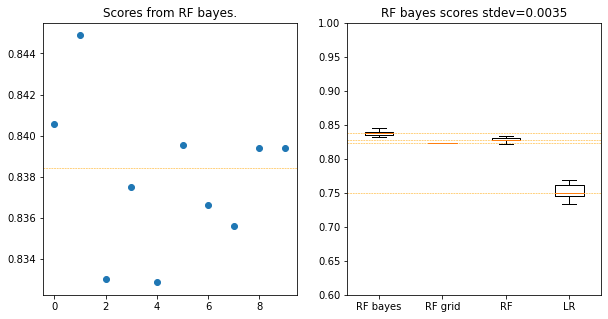

In [27]:
# https://stackoverflow.com/a/45074887/3780957
# Checking the accuracy of the best model

rf_model_after_bayes_search = rf_model_bayes_search.best_estimator_
rf_score_after_bayes = cross_val_score(rf_model_after_bayes_search, X, y, scoring='accuracy', cv=10)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(rf_score_after_bayes), np.std(rf_score_after_bayes)))
plot_scores([rf_score_after_bayes, rf_model_after_search_scores, rf_scores, lr_scores], \
    ['RF bayes', 'RF grid', 'RF', 'LR'])


 ## KNeighborsClassifier
 We tried `KNeighborsClassifier`. Classifier implementing the k-nearest neighbors vote.

Accuracy: 0.7677 (+/- 0.00)


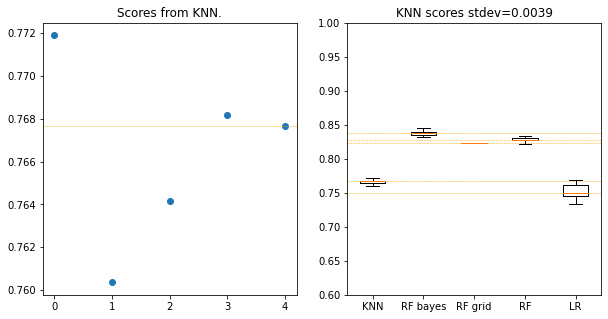

In [28]:
### KNeighborsClassifier ----
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

knn_model = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn_scores = cross_val_score(knn_model, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(knn_scores), np.std(knn_scores)))
plot_scores([knn_scores, rf_score_after_bayes, rf_model_after_search_scores, rf_scores, lr_scores], ['KNN', 'RF bayes', 'RF grid', 'RF', 'LR'])


 ## XGBoost
 XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. <br>
 We had set the library to run in `GPU` to increase tunning performance.<br>
 The performance is very good. We will try hyperparameter tunning.<br>
 More about XGBoost at the [link](https://xgboost.readthedocs.io/en/latest/).

In [29]:
### XGBoost ----


 ### Hyperparameter tunning XGBoost, bayesian search
 Five different parameters will be tunned using random search.<br>
 The performance of this algorithm hasn't improved. For speeding up this *notebook*, we had reduced the number of *parameter combination*.

In [30]:
#### Hyperparameter tunning XGBoost, bayesian search ----
# https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn
# https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html
# https://neptune.ai/blog/scikit-optimize

params = {
        'learning_rate': [0.01, 0.3, 0.5],
        'min_child_weight': [None, 0, 1, 5, 10],
        'gamma': [None, 0, 0.5, 1, 1.5, 2, 5],
        'colsample_bytree': [None, 0.6, 0.8, 1.0],
        'max_depth': [10],
        'subsample': [0.75, 1],
        'n_estimators': [100, 500],
        'max_delta_step': [0.0],
        'colsample_bylevel': [1.0],
        'reg_alpha': [0.0],
        'reg_lambda': [1.0],
        'base_score': [0.5],
        'missing': [None]
        }

folds = 3
param_comb = 100
cv_ = 3

xgb_model_bayes = xgb.XGBClassifier(objective="binary:logistic", random_state=42, tree_method='gpu_hist', gpu_id=0, nthread=-1)
xgb_model_search_bayes = BayesSearchCV(xgb_model_bayes, search_spaces=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=cv_, verbose=3, random_state=42)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_model_search_bayes.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   40.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   40.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   42.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   37.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   46.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   59.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   59.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   57.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished



 Time taken: 1 hours 7 minutes and 27.2 seconds.


Accuracy: 0.8404 (+/- 0.01)


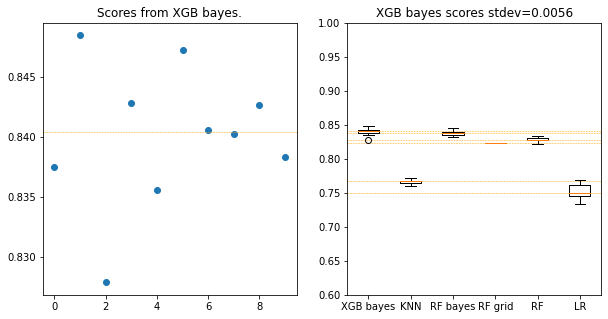

In [31]:
# https://stackoverflow.com/a/45074887/3780957
# Checking the accuracy of the best model

xgb_model_after_bayes_search = xgb_model_search_bayes.best_estimator_
xgb_scores_bayes_tunned = cross_val_score(xgb_model_after_bayes_search, X, y, scoring='accuracy', cv=10)
print("Accuracy: %0.4f (+/- %0.2f)" % (np.median(xgb_scores_bayes_tunned), np.std(xgb_scores_bayes_tunned)))
plot_scores([xgb_scores_bayes_tunned, knn_scores, rf_score_after_bayes, rf_model_after_search_scores, rf_scores, lr_scores], \
    ['XGB bayes', 'KNN', 'RF bayes', 'RF grid', 'RF', 'LR'])


 # Testing dataset
 As mentioned before, the *testing* dataset has been removed to improve the performance for the final assignment validation `accuracy`.

In [32]:
## Testing dataset ----


In [33]:

def model_accuracy(model, df=df_test, decimals=2):
    """Print model `accuracy`

    Args:
        model (object): Sklearn model
        y_pred (Series, optional): Dependent variable. Defaults to y_pred.
        decimals (int, optional): Number of decimals to print the `accuracy`. Defaults to 2.
    """
    X_validation = df.drop([target_encoded], axis=1)
    y_validation = df[target_encoded]
    y_pred = model.predict(X_validation)
    print(model)
    print(f'Accuracy: {(accuracy_score(y_validation, y_pred)*100).round(decimals)}%')


 ## Preprocessing
 Applied the *preprocessing* pipeline.

In [34]:
### Preprocessing ----

# Manual feature construction
df_test = feature_construction(df_test)
# TargetEncoder
df_test = one_hot_encoder(df_test, [map_])
df_test, _ = label_encoder(df_test, target, target_encoded, enc_le_target)
# StandardScaler
df_test, _, _ = scaler_transform(df_test.loc[:, columns_scaler], target_encoded, enc_scaler)
# SymbolicTransformer
df_test, _, _ = symbolic_transformer_fit(df_test.loc[:, columns_symbolic], enc_gp)
# PCA
df_test, _, _ = pca_transform(data=df_test, target=target_encoded, n=19, encoder=enc_pca)


 ## Model predict
 Applied the *tunned* models.

In [35]:
### Model predict ----


In [36]:
model_accuracy(lr_model.fit(X, y), df=df_test)
model_accuracy(rf_model.fit(X, y), df=df_test)
model_accuracy(rf_model_after_search, df=df_test)
model_accuracy(rf_model_after_bayes_search, df=df_test)
model_accuracy(knn_model.fit(X, y), df=df_test)
model_accuracy(xgb_model_after_bayes_search, df=df_test)


LogisticRegression()
Accuracy: 74.41%
RandomForestClassifier(n_jobs=-1, random_state=0)
Accuracy: 84.34%
RandomForestClassifier(max_depth=100, n_estimators=600, n_jobs=-1,
                       random_state=0)
Accuracy: 84.77%
RandomForestClassifier(max_depth=200, n_estimators=1200, n_jobs=-1,
                       random_state=0)
Accuracy: 84.86%
KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Accuracy: 76.6%
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0.0, max_depth=10,
              min_child_weight=0, missing=None,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=301, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=42, reg_alpha=0.0, reg_lambda=1.0,
              scale_pos_weight=1, subsample

 # Storing the models

In [37]:
## Model save ----
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

filename = 'storage/lr_model.sav'
pickle.dump(lr_model, open(filename, 'wb'))

filename = 'storage/rf_model.sav'
pickle.dump(rf_model, open(filename, 'wb'))

filename = 'storage/rf_model_after_search.sav'
pickle.dump(rf_model_after_search, open(filename, 'wb'))

filename = 'storage/rf_model_after_bayes_search.sav'
pickle.dump(rf_model_after_bayes_search, open(filename, 'wb'))

filename = 'storage/knn_model.sav'
pickle.dump(knn_model, open(filename, 'wb'))

filename = 'storage/xgb_model_after_bayes_search.sav'
pickle.dump(xgb_model_after_bayes_search, open(filename, 'wb'))


# Validation dataset
 The class validation will be done using the following dataset `modeling_set.csv`.<br>
 Here, we also applied the *preprocessing* and the different models to test the performance.

In [38]:
## Validation dataset ----


 ## Loading data
 Loading the previously mentioned `validation_set.csv`.

In [39]:
### Loading data ----
df_validation = pd.read_csv('raw/validation_set.csv')


 ## Preprocessing
 Applied the *preprocessing* pipeline.

In [40]:
### Preprocessing ----

# Manual feature construction
df_validation = feature_construction(df_validation)
# TargetEncoder
df_validation = one_hot_encoder(df_validation, [map_])
df_validation, _ = label_encoder(df_validation, target, target_encoded, enc_le_target)
# StandardScaler
df_validation, _, _ = scaler_transform(df_validation.loc[:, columns_scaler], target_encoded, enc_scaler)
# SymbolicTransformer
df_validation, _, _ = symbolic_transformer_fit(df_validation.loc[:, columns_symbolic], enc_gp)
# PCA
df_validation, _, _ = pca_transform(data=df_validation, target=target_encoded, n=19, encoder=enc_pca)


 ## Model predict
 Applied the *tunned* models.

In [41]:
### Model predict ----


In [42]:
model_accuracy(lr_model.fit(X, y), df=df_validation)
model_accuracy(rf_model.fit(X, y), df=df_validation)
model_accuracy(rf_model_after_search, df=df_validation)
model_accuracy(rf_model_after_bayes_search, df=df_validation)
model_accuracy(knn_model.fit(X, y), df=df_validation)
model_accuracy(xgb_model_after_bayes_search, df=df_validation)


LogisticRegression()
Accuracy: 74.62%
RandomForestClassifier(n_jobs=-1, random_state=0)
Accuracy: 84.5%
RandomForestClassifier(max_depth=100, n_estimators=600, n_jobs=-1,
                       random_state=0)
Accuracy: 84.87%
RandomForestClassifier(max_depth=200, n_estimators=1200, n_jobs=-1,
                       random_state=0)
Accuracy: 84.88%
KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Accuracy: 76.49%
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0.0, max_depth=10,
              min_child_weight=0, missing=None,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=301, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=42, reg_alpha=0.0, reg_lambda=1.0,
              scale_pos_weight=1, subsample

# Final prediction for grading
 The final prediction fort the grading process, is taking into account all the previous learnings.<br>
 In particular, and for computing time limitations, we will use `Random Forest` to predict into the `validation` dataset.

In [43]:
import matplotlib.pyplot as plt
from collections import defaultdict

In [44]:
categorical_columns = ['map', 'time_left']

Data pre processingTransform the `time_left` column from a continuos distribution into 6 intervals

In [45]:
data_train = pd.read_csv("raw/modeling_set.csv")

In [46]:
data_train.time_left = pd.cut(data_train.time_left,bins=[0,50,75,100,125, 150, 175],labels=[1,2,3,4,5,6])

In [47]:
columns_to_add = defaultdict(list)
for col in categorical_columns:
    dummies = pd.get_dummies(data_train[col], prefix=col)
    data_train = pd.concat([data_train, dummies], axis=1)
    data_train.drop(col, axis=1, inplace=True)
    columns_to_add[col] += [new_col.replace(col + "_", "") for new_col in dummies.columns]

In [48]:
data_train.round_winner = data_train.round_winner.astype('category').cat.codes

In [49]:
data_test = pd.read_csv("raw/validation_set.csv")

In [50]:
data_test.time_left = pd.cut(data_test.time_left,bins=[0,50,75,100,125, 150, 175],labels=[1,2,3,4,5,6])

In [51]:
columns_to_add = defaultdict(list)
for col in categorical_columns:
    dummies = pd.get_dummies(data_test[col], prefix=col)
    data_test = pd.concat([data_test, dummies], axis=1)
    data_test.drop(col, axis=1, inplace=True)
    columns_to_add[col] += [new_col.replace(col + "_", "") for new_col in dummies.columns]

In [52]:
data_test.round_winner = data_test.round_winner.astype('category').cat.codes

In [53]:
X_train = data_train.drop("round_winner", axis=1)
X_test = data_test.drop("round_winner", axis=1)
y_train = data_train["round_winner"]
y_test = data_test["round_winner"]

Random Forest modelling

In [54]:
rfc = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['auto'],
    'max_depth' : [10, 20, 30],
    'criterion' :['entropy'], 
    "min_samples_split": [2, 3, 5, 10]
}


In [55]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 300}

In [56]:
from sklearn.metrics import accuracy_score
y_pred = rfc.fit(X_train, y_train).predict(X_test)
print("#Mislabeled points (RF) : {1} out of {0}".format(len(y_test), sum(y_pred != y_test)))
print("Model Accuray: {:.4f}".format(accuracy_score(y_test, y_pred)))

#Mislabeled points (RF) : 4782 out of 36723
Model Accuray: 0.8698


In [57]:
filename = 'storage/rfc.sav'
pickle.dump(rfc, open(filename, 'wb'))

 ## Prediction
 Prediction using our best model.

In [58]:
### Prediction ----
y_pred = rfc.fit(X_train, y_train).predict(X_test)

np.savetxt("results/prediction_RF.csv", y_pred, delimiter=",", fmt='%s')